In [317]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
import itertools
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later

criteria_dict = {"cs_name_val" : 12}
project = signac.get_project("GPBO_Fix")
save_csv = False
save_figs = False
analyzer = General_Analysis(criteria_dict, project, mode = "act", save_csv = save_csv)
plotters = Plotters(analyzer, save_figs)

In [318]:
def grid_sampling(num_points, bounds):
        """
        Generates Grid sampled data
        
        Parameters
        ----------
        num_points: int, number of points in LHS, should be greater than # of dimensions
        bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
        
        Returns:
        ----------
        grid_data: ndarray, (num_points)**bounds.shape[1] grid sample of data
        
        """
        #Generate mesh_grid data for theta_set in 2D
        #Define linspace for theta
        params = np.linspace(0,1, num_points)
        #Define dimensions of parameter
        dimensions = bounds.shape[1]
        #Generate the equivalent of all meshgrid points
        df = pd.DataFrame(list(itertools.product(params, repeat=dimensions)))
        df2 = df.drop_duplicates()
        scaled_data = df2.to_numpy()
        #Normalize to bounds 
        lower_bound = bounds[0]
        upper_bound = bounds[1]
        grid_data = scaled_data*(upper_bound - lower_bound) + lower_bound 
        return grid_data

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(xx, yy, x, y, args):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all Theta1 values
            
        yy: An D X N array of all Theta2 values
        theta: parameter vector
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    sse = np.zeros([len(xx),len(yy)])
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            theta = np.array([xx[i][j],yy[i][j]])
            sse[i][j] = sum((y - uniquac_model(theta,x, args))**2) 
    
    return sse

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta_guess, x, y, args=None):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        theta_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    
    error = y - calc_mm_model(theta_guess,x, args); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

def calc_gamma_exp(Xexp, P, y1, theta_ref, args):
    # Extract parameters
    r = np.array(args["r"])
    q = np.array(args["q"])
    z = args.get("z", 10)
    R = args["R"]
    T = args["T"]
    A, B, C = np.array(args["A"]), np.array(args["B"]), np.array(args["C"])
    
    l = (z / 2) * (r - q) - (r - 1)
    tau = np.exp(-theta_ref / (R * T))
    psat = 10 ** (A - (B / (C + (T - 273.15))))
    term1 = np.log(r[0]/r[1])
    term2a = 5*np.log((q[0]*r[1])/(q[1]*r[0])) - np.log(tau[1]) + 1 -tau[0]
    term2 = q[0]*term2a
    term3 = l[0]-(r[0]/r[1])*l[1]
    gamma_inf1 = np.exp(term1 + term2 + term3)

    term1_x2 = np.log(r[1]/r[0])
    term2a_x2 = 5*np.log((q[1]*r[0])/(q[0]*r[1])) - np.log(tau[0]) + 1 -tau[1]
    term2_x2 = q[1]*term2a_x2
    term3_x2 = l[1]-(r[1]/r[0])*l[0]
    gamma_inf2 = np.exp(term1_x2 + term2_x2 + term3_x2)
    gamma = []
    for i in range(len(Xexp)):
        if Xexp[i] == 0:
            gamma.append(gamma_inf1)
        elif Xexp[i] == 1:
            gamma.append(gamma_inf2)
        else:
            value = P[i]*y1[i]/(psat[0]*Xexp[i])
            gamma.append(value)
    return np.array(gamma) #Gamma1
#gamma[~valid_mask[0,0], 0] = gamma_inf[0]  # Where x1 = 0
def uniquac_model(unknown_params, xP, args):
    """
    Compute activity coefficients using the UNIQUAC model for a binary mixture.

    Parameters:
    unknown_params : np.array
        A vector containing the unknown interaction energy parameters Δu_ij.
    xP : np.array or float
        Mole fractions x1 (x2 is inferred).
    args : dict
        A dictionary containing necessary additional parameters:
        - "r": np.array, volume parameters for components
        - "q": np.array, surface area parameters for components
        - "R": float, gas constant
        - "T": float, temperature
        - "z": float, coordination number (default 10)
        - "A", "B", "C": Antoine equation parameters for vapor pressure

    Returns:
    np.array or float
        Vapor pressure P.
    """
    # Extract parameters
    r = np.array(args["r"])
    q = np.array(args["q"])
    z = args.get("z", 10)
    R = args["R"]
    T = args["T"]
    A, B, C = np.array(args["A"]), np.array(args["B"]), np.array(args["C"])
    mode = args["mode"]
    
    # Precompute constants
    l = (z / 2) * (r - q) - (r - 1)
    tau = np.exp(-unknown_params / (R * T))
    psat = 10 ** (A - B / (C + (T - 273.15)))

    # Ensure xP is at least 1D
    x1 = np.atleast_2d(xP).reshape(-1,1)
    x2 = 1 - x1
    x = np.hstack([x1, x2])

    # Initialize gamma with ones
    gamma = np.ones_like(x, dtype=float)

    # Identify valid indices where both x1 and x2 are nonzero
    valid_mask = (x1.flatten() > 0) & (x2.flatten() > 0)

    if np.any(valid_mask):
        # Apply valid_mask correctly to both dimensions
        valid_x = x[valid_mask, :]  # Shape (M, 2) where M is number of valid rows

        sum_xq = np.dot(valid_x, q)
        sum_xr = np.dot(valid_x, r)

        theta = (valid_x * q) / sum_xq[:, None]
        psi = (valid_x * r) / sum_xr[:, None]

        lngC = (
            np.log(psi / valid_x) + (z / 2) * q * np.log(theta / psi) + psi[:, ::-1] * (l - r * l[::-1] / r[::-1])
        )

        lngR = (
            -q * np.log(theta + theta[:, ::-1] * tau[::-1]) + theta[:, ::-1] * q * (
                tau[::-1] / (theta + theta[:, ::-1] * tau[::-1]) - tau / (theta[:, ::-1] + theta * tau)
            )
        )

        gamma[valid_mask, :] = np.exp(lngC + lngR)
        
    # Handle infinite dilution cases
    if np.any(~valid_mask):
        # Compute gamma at infinite dilution for both components
        gamma_inf = np.zeros(2)

        # term1 = 1- (r[0]/r[1]) +np.log(r[0]/r[1])
        # term2 = -5*q[0]*(1-(r[0]*q[1])/(r[1]*q[0]) + np.log((r[0]*q[1])/(r[1]*q[0])))

        term1 = np.log(r[0]/r[1])
        term2a = 5*np.log((q[0]*r[1])/(q[1]*r[0])) - np.log(tau[1]) + 1 -tau[0]
        term2 = q[0]*term2a
        term3 = l[0]-(r[0]/r[1])*l[1]
        gamma_inf[0] = np.exp(term1 + term2 + term3)

        term1_x2 = np.log(r[1]/r[0])
        term2a_x2 = 5*np.log((q[1]*r[0])/(q[0]*r[1])) - np.log(tau[0]) + 1 -tau[1]
        term2_x2 = q[1]*term2a_x2
        term3_x2 = l[1]-(r[1]/r[0])*l[0]
        gamma_inf[1] = np.exp(term1_x2 + term2_x2 + term3_x2)

    gamma1 = gamma[:, 0]
    gamma2 = gamma[:, 1]

    #Manually alter gamma values at infinite dilution
    if np.any(x2.flatten() == 0):
        gamma2[-1] = gamma_inf[1]
    if np.any(x1.flatten() == 0):
        gamma1[0] = gamma_inf[0]
        

    P = np.sum(x * gamma * psat, axis=1)
    y = x*gamma*psat/P[:, None]
    if mode == "P":
        var = P # Return scalar if input was scalar-like
    elif mode == "gamma":
        var = gamma1 #Return gamma1
    elif mode == "y":
        var = y[:,0] #Return y1

    return var #var[0] if var.shape == (1,) else var 
    
def calc_mm_model(model_coefficients, x, args = None):
    """
    Caclulates the Muller Potential
    
    Parameters
    ----------
        model_coefficients: ndarray, The array containing the values of Muller constants
        x: ndarray, Values of X
        noise: ndarray, Any noise associated with the model calculation
    
    Returns:
    --------
        y_mul: float, value of Muller potential
    """    
    theta = model_coefficients
    # y_mul = (theta[0] * x**3 - theta[1] * x**2 + 2*x - 1)**2 + (theta[0] - theta[1])**2 + (x**2 - 1)**2 #MC Example
    # y_mul = np.exp(theta[0]-theta[3]*x) + np.exp(theta[1]-theta[4]*x) - np.exp(theta[2]-theta[5]*x) #Pharmacokinetic model
    y_mul = uniquac_model(theta, x, args)
    return y_mul
argsvals = None

In [319]:
##New Cell

## define function that includes nonlinear model
def model(theta_guess, theta_ref, x, indeces_to_consider, args=None):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Define an array to store y values in
    y_data = []
    #Loop over all theta values
    for i in range(len(x)):
        #Create model coefficient from true space substituting in the values of param_space at the correct indeces
        model_coefficients = theta_ref.copy()
        #Replace coefficients a specified indeces with their theta_val counterparts
        model_coefficients[indeces_to_consider] = theta_guess              
        #Create y data coefficients
        y = calc_mm_model(model_coefficients, x[i], args)
        y_data.append(y)
        # print(model_coefficients, x[i], y)

    #Convert list to array and flatten array
    y_model = np.array(y_data).flatten()
    
    return y_model

# X_pred = np.linspace(np.min(Xexp),np.max(Xexp),100).reshape(-1,1)
# print(model(theta_true, theta_true, Xexp, indeces_to_consider,argsvals))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta_guess, theta_ref, x, indeces_to_consider, y, args=None):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    error = y - model(theta_guess, theta_ref, x, indeces_to_consider, args) #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

# print(regression_func(theta_true, theta_true, Xexp, indeces_to_consider, Yexp, argsvals))

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(theta_guesses, theta_ref, indeces_to_consider, Xexp, Yexp, args):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all a_1 values
        yy: An D X N array of all a_2 values
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    #Initialize sse grid
    sse = np.zeros(len(theta_guesses))
    
    #For each guess
    for i in range(len(theta_guesses)):
        #Evaluate the model
        y_sim = model(theta_guesses[i], theta_ref, Xexp, indeces_to_consider, args)
        #Calculate SSE
        sse[i] = np.sum((y_sim - Yexp)**2)
     
    sse = sse.reshape(int(np.sqrt(len(theta_guesses))), -1).T
    
    return sse

# print(sse_func([theta_true], theta_true, indeces_to_consider, Xexp, Yexp, argsvals))

In [320]:
#MC Example (Well Posed, 2 min)
#in 5 restarts, 1 local min found (4), and one global min (1)
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[-2], [1.5]])
# bounds_theta_l = [-2,-2]
# bounds_theta_u = [2,2]
# theta_ref = np.array([-1.5, 0.5 ]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#Pharmacokinetic model (Use this if VLE methods fail)
# William R. Esposito, Christodoulos A. Floudas, Parameter estimation in nonlinear algebraic models via global optimization, 
# Computers & Chemical Engineering, Volume 22, Supplement 1, 1998, Pages S213-S220, ISSN 0098-1354, https://doi.org/10.1016/S0098-1354(98)00217-8.
#w/ Xexp Data + Ysim (std = 0.01*mean) 2 mins; w/ 5 restart global min(correct x3), local min x2)
# param_name_str = "t1t2t3t4t5t6"
# indeces_to_consider = [0,1,2,3,4,5]
# bounds_x = np.array([[4], [120]])
# bounds_theta_l = [-2.302, 1e-4,1e-4,1e-4,1e-4,1e-4 ]
# bounds_theta_u = [1e-4, 2.302, 2.302, 0.5,0.5,0.5]
# theta_ref = np.array([-1.0345, 0.6966, 1.5200, 0.01491, 0.1102, 0.2847]) 
# Xexp = np.array([4,8,12,23,45,75,95,120])
# theta_names = ['theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#VLE DMSO + Water (DECHEMA 1C pg 257) (Use this as VLE last resort)
#Exp Data 2 min; 19 true, 30 local, 5 restarts - none found, 20 restarts one of each min is found 
#Exp Data + Ysim (std=0.01*mean) 3 min (148 true, 117 + 1 local); 5 restarts = 1 local soln.
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e4,-1e4]
# bounds_theta_u = [1e4,1e4]
# theta_ref = np.array([-252.5845, -536.5967]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([2.0,3.5,4.0,13.0,18.50,27.0,37.0,46.0,51.0,51.5,52.5,54.0,54.0,55.0])
# Xexp = np.array([0.0,0.1289,0.1530,0.4467,0.5324,0.6761,0.8064,0.8887,0.9177,0.9279,0.9624,0.9863,0.9875,1.00])
# argsvals = {"r" :[0.92, 2.8266], #H2O + DMSO
#         "q" :[1.4, 2.4720],
#         "T" : 40+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.07372,6.95133],
#         "B": [1730.63, 1541.52],
#         "C": [233.426, 191.797],
#         "mode": "P"
#         }
# Yexp_org = P

#VLE ACN + Water (DECHEMA 1C pg 127) (Definitely Use This Example)
#Exp Data 6 local min 352(true) 311 330   1   1   1] 5 - 1("true") + 4 (1 & 3) local min
#Exp Data + Ysim (std=0.01*mean) 8 local min [361 (true) 306 274   1   2   1  12  36]; 5- 1 ("true") + (1 & 3) local min
param_name_str = "t1t2"
indeces_to_consider = [0,1]
bounds_x = np.array([[0], [1]])
bounds_theta_l = [-1e4,-5e3 ]
bounds_theta_u = [1e4,1e4]
theta_ref = np.array([436.4803,225.3647]) 
theta_names = ['theta_1', 'theta_2']
theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
Xexp = np.array([0.0087,0.0269,0.0568,0.1556,0.2749,0.4449,0.661,0.8096,0.9309,0.9578])
y1 = np.array([0.2041,0.4254,0.5713,0.6799,0.7017,0.7118,0.7306,0.7704,0.8776,0.9136])
argsvals = {"r" :[1.8701,0.92], #ACN, H2O
        "q" :[1.7240,1.4],
        "T" : 50+273.15, #K
        "R" : 1.98721 , #cal/molK
        "A": [7.33986,8.07131],
        "B": [1482.29,1730.63],
        "C": [250.523,233.426],
        "mode": "y"
        } 
Yexp_org = y1

#VLE Water + Glycerol (DECHEMA 1C pg 389) (Use This Example if other is bad (w/ Sim Data))
#Exp data 3 local min, neither true
#Xexp Data + Ysim (std=0.01*mean) 3 min 11(true) 51  2; 5 no mins found, at 30, 1 local min
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3]
# bounds_theta_u = [1.2e3,1.2e3]
# theta_ref = np.array([27.584,-195.9166]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([142.5,212.0,305.0,425.0,534.5,674.5,723.5,731.0,755.0,760.0])
# Xexp = np.array([0.0,0.1115,0.2475,0.4076,0.5939,0.8230,0.9214,0.9296,0.985,1.000])
# argsvals = {"r" :[0.92, 3.5857], #H2O + Glycerol
#         "q" :[1.4, 3.06],
#         "T" : 100+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.07225,7.10850],
#         "B": [1730.63, 1537.78],
#         "C": [233.426, 210.39],
#         "mode": "P"
#         }
# Yexp_org = P

restarts = 1000

0.0


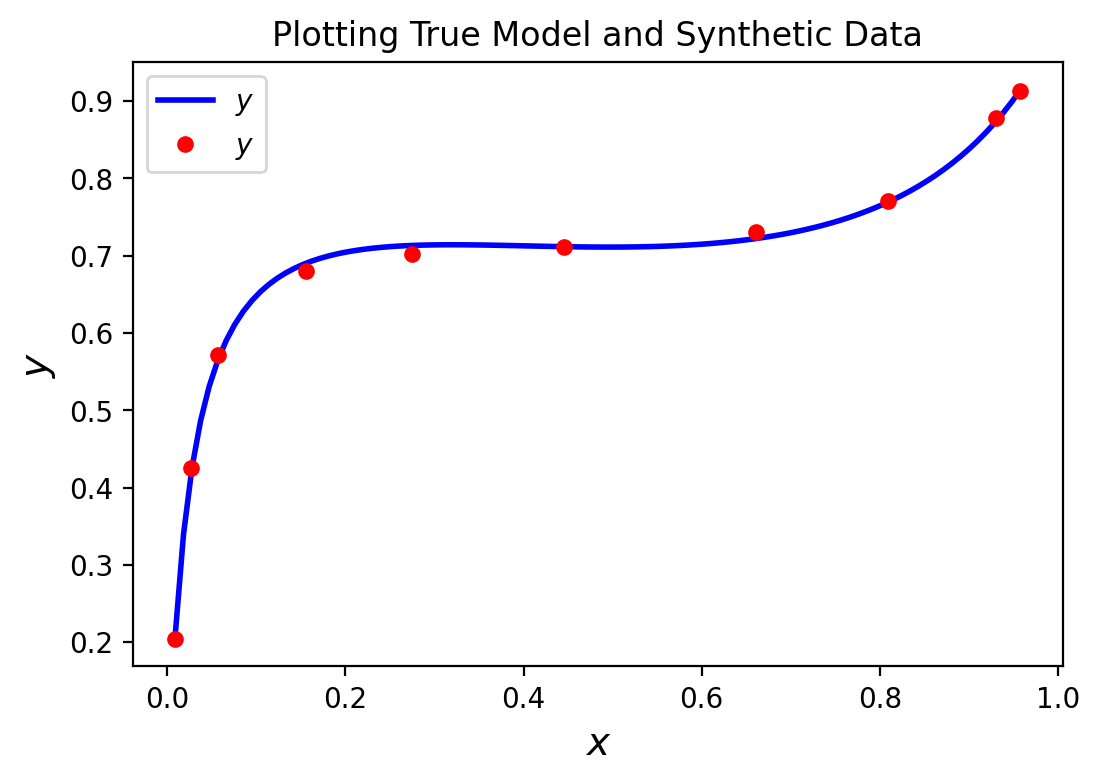

In [321]:
num_params = len(theta_ref)
np.random.seed(1)
# Evaluate model and add noise based on assumed theta values
# This generates experimental data points (If you don't want to define them above)
# num_points = 10 #len(Xexp)
# Xexp = grid_sampling(num_points, bounds_x)
std_mult = 0.0
# Yexp_org = np.array([ calc_mm_model(theta_ref, Xexp[i], argsvals)  for i in range(len(Xexp)) ]).flatten()
# std_mult = 0.01
std = abs(np.mean(Yexp_org))*std_mult
print(std)
noise = np.random.normal(size=len(Yexp_org), loc = 0, scale = std)
# print(Yexp_org)
Yexp = Yexp_org + noise

# Evaluate model based on the assumed experimental values
X = np.linspace(np.min(Xexp),np.max(Xexp),100).reshape(-1,1)
Y = calc_mm_model(theta_ref, X.reshape(-1,1),argsvals)
# Compare the experiments to the true model
plt.plot(X,Y,'b-',linewidth=2,label=r"$y$")
plt.plot(Xexp,Yexp,'r.',markersize=10,label=r"$y$")
plt.title("Plotting True Model and Synthetic Data")
plt.xlabel(r"$x$",fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
plt.legend()
plt.show()

In [322]:
#New Cell
# Create synthetic data assuming the following values for theta
Theta_Guess = np.array([1,1])

# print(calc_cs1_polynomial(Theta_Guess,Xexp))
## specify initial guess
sse_list = []
opt_list = []
theta_list = []

## specify bounds
lower = np.array([bounds_theta_l[i] for i in indeces_to_consider] )
upper = np.array([bounds_theta_u[i] for i in indeces_to_consider] )
bounds = (lower, upper)

for i in range(restarts):
    theta_guess = np.random.uniform(low=lower, high=upper, size=len(lower) )
    # print(theta_guess)
    Solution = optimize.least_squares(regression_func, theta_guess, bounds=bounds, method='trf',
                                        args=(theta_true, Xexp.reshape(-1,1), indeces_to_consider, Yexp, argsvals),verbose=0)

    theta = Solution.x
    sse_list.append(Solution.cost)
    theta_list.append(theta)
    opt_list.append(Solution.optimality)
    # print("theta = ",theta)

all_sets = pd.DataFrame({'Theta': theta_list, 'SSE': sse_list, 'Optimality': opt_list})

# print(all_sets)
#Organize all_sets by SSE, lowest to highest
all_sets = all_sets.sort_values(by="SSE", ascending=True)

print(len(all_sets))

1000


In [323]:
# # Drop duplicate minima
all_sets = all_sets.drop_duplicates(
    subset="SSE", keep="first")
# # Drop minima with optimality > 1e-4
all_sets = all_sets[all_sets["Optimality"] < 1e-3]

In [324]:
print(all_sets)

                                        Theta       SSE    Optimality
250   [385.6655484341997, 258.27673524542166]  0.000162  1.938634e-08
999   [385.66548173771406, 258.2767778494973]  0.000162  1.644142e-08
862   [385.66548172768114, 258.2767781907998]  0.000162  1.160467e-08
455    [385.6654816683146, 258.2767779439666]  0.000162  1.972001e-08
808   [385.6655548859952, 258.27673101098435]  0.000162  2.677606e-08
..                                        ...       ...           ...
38      [-9999.999999999998, 3473.6553508956]  0.459320  2.814618e-06
563  [-9999.999999999998, 3476.4916208853697]  0.459320  4.121234e-06
513  [-9999.999999999998, 3476.6320850715397]  0.459320  4.496852e-06
703  [-9999.999999999998, 3476.8863418257088]  0.459320  5.186800e-06
544  [-9999.999999999998, 3472.0361380436398]  0.459320  6.247901e-06

[999 rows x 3 columns]


In [325]:
#Scale values between 0 and 1 with minmax scaler
scaler = MinMaxScaler()
scaler.fit([bounds_theta_l, bounds_theta_u])
all_param_sets = np.array(list(map(np.array, all_sets["Theta"].values)))
all_param_sets_scaled = scaler.transform(all_param_sets)
#Calculate the scaled euclidean distance between each pair of scaled points
dist = pdist(all_param_sets_scaled)/np.sqrt(all_param_sets.shape[1])
#Convert the condensed distance matrix to square form
dist_sq = squareform(dist)

#Initialize a boolean array to keep track of unique sets
unique_mask = np.ones(all_param_sets.shape[0], dtype=bool)
duplicate_counts = np.zeros(all_param_sets.shape[0], dtype=int)

# Iterate over the upper triangle of the distance matrix
for i in range(all_param_sets.shape[0]):
    # If the current set is already marked as non-unique, skip it
    if not unique_mask[i]:
        continue
    # Mark sets within the threshold distance as non-unique
    within_threshold = dist_sq[i] <= 0.01
    duplicate_counts[i] = np.sum(within_threshold)
    unique_mask[within_threshold] = False
    unique_mask[i] = True  # Keep the current set

# Filter out the unique sets from the pandas df
local_min_sets = all_sets[unique_mask]
local_min_counts = duplicate_counts[unique_mask]

print("Num local min count", local_min_counts)

print("Num local min", len(local_min_sets))
print(local_min_sets)

# print(all_sets)print("Best Theta = ", nlr_theta)
try:
    nlr_theta = local_min_sets.iloc[0]['Theta']
except:
    nlr_theta = local_min_sets.iloc[0]['Theta']
nlr_thetas = np.vstack(local_min_sets['Theta'])

print("Best Theta = ", nlr_theta)
print("theta_ref", theta_true)
Y_nlr_exp = model(nlr_theta, theta_true, Xexp, indeces_to_consider, argsvals)
error = (Yexp - Y_nlr_exp)
print("SSE = ", np.sum(error**2))

Num local min count [373 305 270   1   1   1  14  34]
Num local min 8
                                        Theta       SSE    Optimality
250   [385.6655484341997, 258.27673524542166]  0.000162  1.938634e-08
181  [9999.999999999996, -293.27007698617876]  0.040489  2.266543e-08
64    [-4239.861155185475, 4239.720503526547]  0.431873  1.914680e-06
753   [-4240.751332756542, 6924.238697159858]  0.431874  3.288410e-05
300   [-4240.753148928996, 8432.939360327513]  0.431874  1.166001e-06
514   [-4240.753010129525, 9088.443386397594]  0.431874  7.072388e-07
198  [-9980.917455627878, -4429.529070918987]  0.433950  1.229697e-05
165   [-9999.999999999998, 3474.965654707035]  0.459320  2.402743e-08
Best Theta =  [385.66554843 258.27673525]
theta_ref [436.4803 225.3647]
SSE =  0.00032315558109480036


In [326]:
#Create heat map data
#Create list of heat map theta data
heat_map_data_dict = {}

#Create a linspace for the number of dimensions and define number of points
dim_theta = num_params
dim_list = np.linspace(0, dim_theta-1, dim_theta)

#Create a list of all combinations (without repeats e.g no (1,1), (2,2)) of dimensions of theta
mesh_combos = np.array(list(combinations(dim_list, 2)), dtype = int)
n_points = 20

#Meshgrid set always defined by n_points**2
theta_set = np.tile(np.array(theta_ref), (n_points**2, 1))

#Set x_vals
norm_x_vals = Xexp.reshape(-1,1)

#Loop over all possible theta combinations of 2
for i in range(len(mesh_combos)):
    #Create a copy of the true values to change the mehsgrid valus on
    theta_set_copy = np.copy(theta_set)
    #Set the indeces of theta_set for evaluation as each row of mesh_combos
    idcs = mesh_combos[i]
    #define name of parameter set as tuple ("param_1,param_2")
    data_set_name = (theta_true_names[idcs[0]], theta_true_names[idcs[1]])

    #Create a meshgrid of values of the 2 selected values of theta and reshape to the correct shape
    #Assume that theta1 and theta2 have equal number of points on the meshgrid
    theta1 = np.linspace(lower[idcs[0]], upper[idcs[0]], n_points)
    theta2 = np.linspace(lower[idcs[1]], upper[idcs[1]], n_points)
    theta12_mesh = np.array(np.meshgrid(theta1, theta2))
    theta12_vals = np.array(theta12_mesh).T.reshape(-1,2)

    #Set initial values for evaluation (true values) to meshgrid values
    theta_set_copy[:,idcs] = theta12_vals
    
    #Append data set to dictionary with name
    heat_map_data_dict[data_set_name] = theta_set_copy
    
hm_data_keys = list(heat_map_data_dict.keys())

In [327]:
print(nlr_thetas)

[[   385.66554843    258.27673525]
 [ 10000.           -293.27007699]
 [ -4239.86115519   4239.72050353]
 [ -4240.75133276   6924.23869716]
 [ -4240.75314893   8432.93936033]
 [ -4240.75301013   9088.4433864 ]
 [ -9980.91745563  -4429.52907092]
 [-10000.           3474.96565471]]


/scratch365/mcarlozo/Toy_Problem/bo_methods_lib/bo_methods_lib/GPBO_Classes_plotters.py:2205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


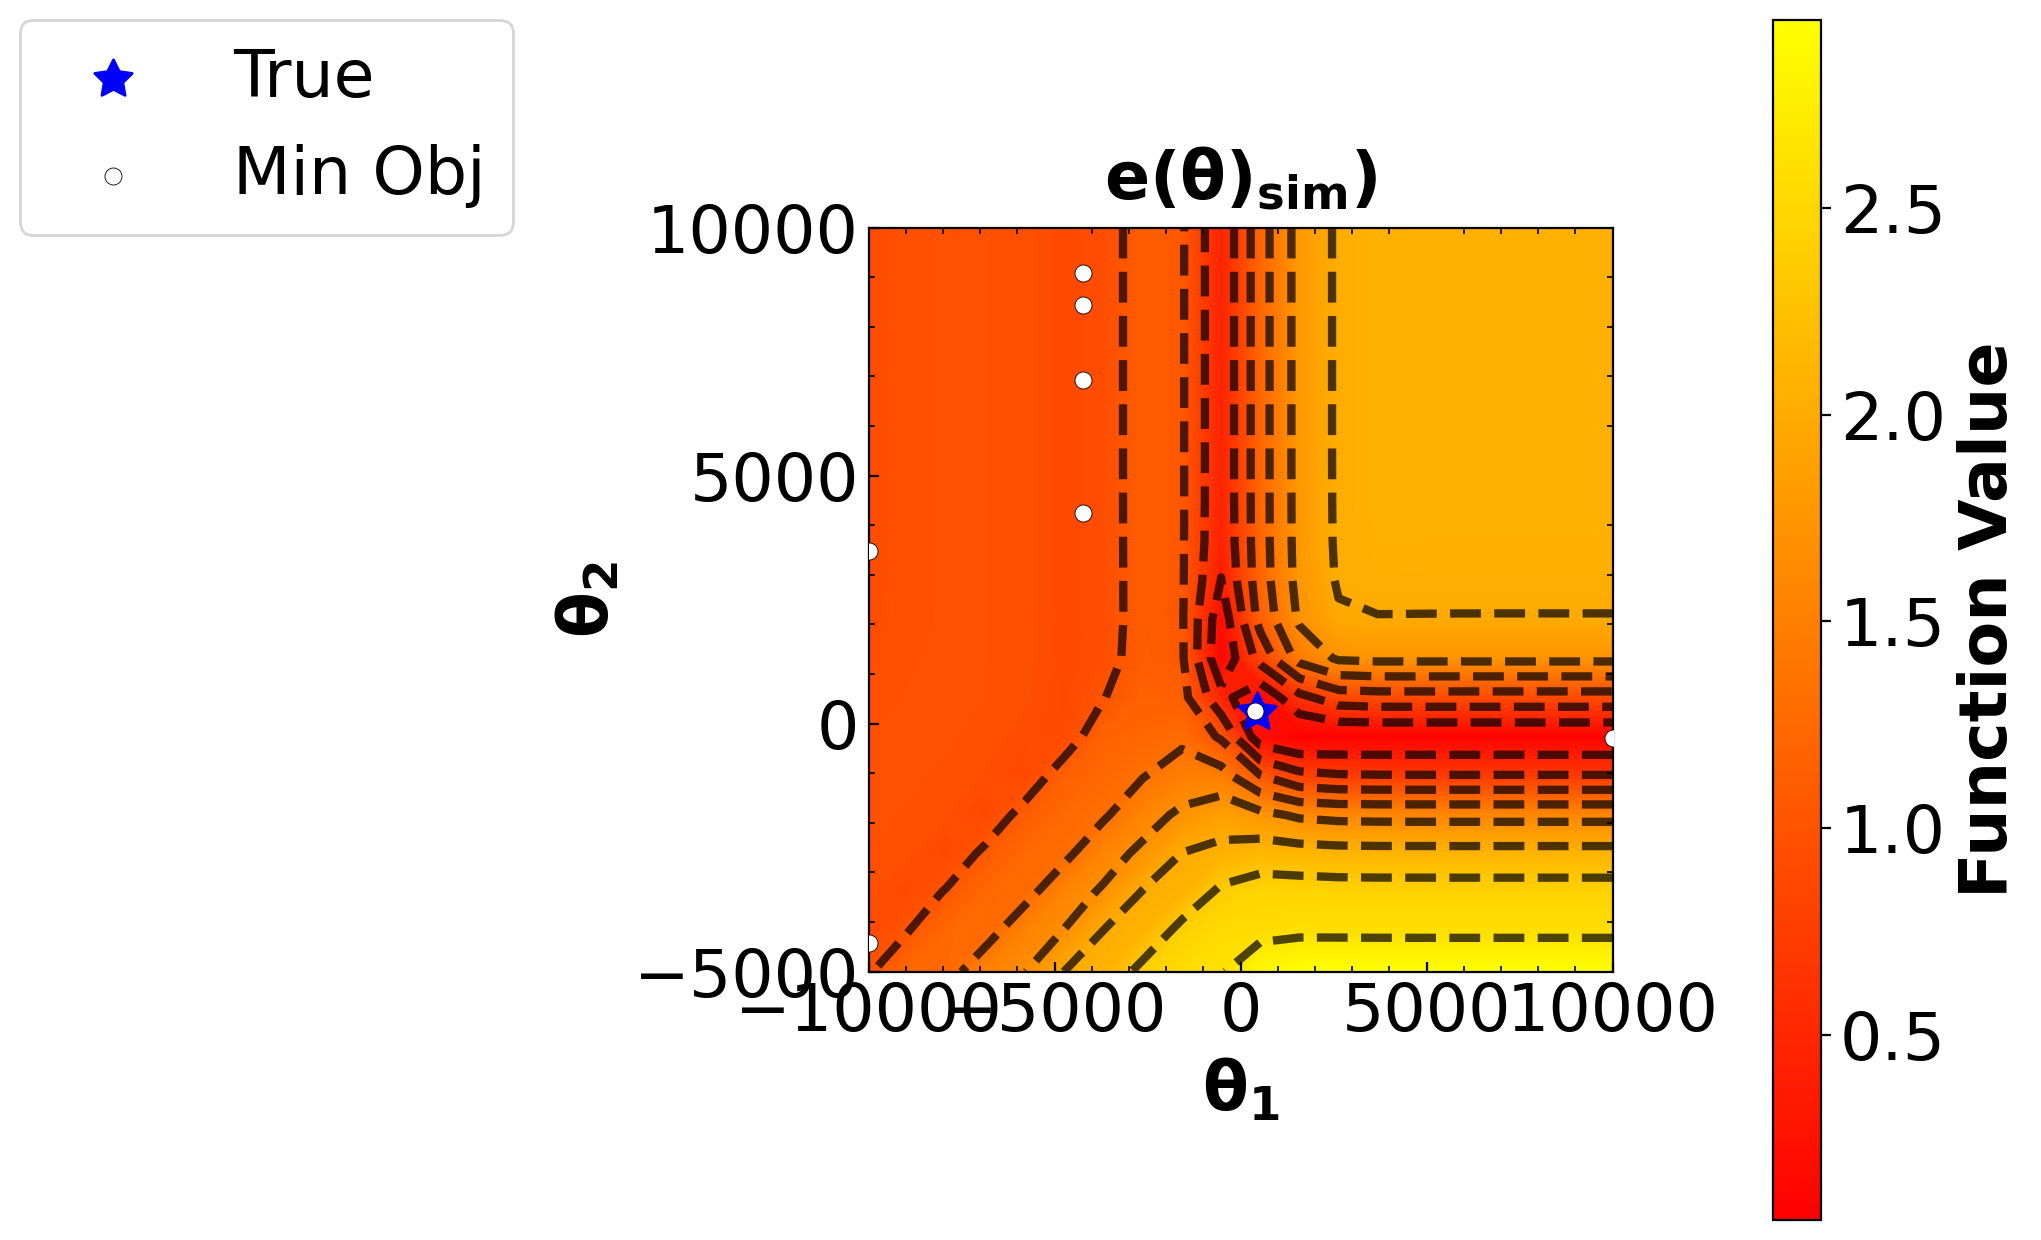

In [328]:
#New Cell
log_data = False
# save_figure = True
save_figure = False

#Get Number of pairs
combos = list(combinations(dim_list, 2))
pairs = len((list(combinations(dim_list, 2))))

#For each pair
for pair in range(pairs):
    #Make a meshgrid for each parameter
    idcs_to_plot = [int(combos[pair][i]) for i in range(len(combos[pair]))]
    theta_data = heat_map_data_dict[hm_data_keys[pair]].reshape(n_points, n_points, -1).T
    theta_mesh = np.take(theta_data, list(combos[pair]), axis=0)
    
    sse_sim = sse_func(heat_map_data_dict[hm_data_keys[pair]], theta_ref, indeces_to_consider, Xexp.reshape(-1,1), Yexp, argsvals)
    param_names = theta_true_names[idcs_to_plot]
    
    title = "Heat Map Pair " + "-".join(map(str, param_names))
    title = None

    z = np.array([sse_sim])
    # print(np.amin(z), np.amax(z))
    if log_data == True:
        z_titles = ["ln("+ r"$\mathbf{e(\theta)_{sim}}$" + ")"]
        z = np.log(z)
    else:
        z_titles = [r"$\mathbf{e(\theta)_{sim}}$" + ")"]
    
#     z_save_names = ["sse_sim", "sse_nlr"]
#     path_end = '-'.join(z_save_names) 
    levels = [100]

    param_info_dict = {"true":theta_true, "min_sse":nlr_thetas, "names":param_names, "idcs":idcs_to_plot}
    plotters.plot_nlr_heat_maps(theta_mesh, z, z_titles, levels, param_info_dict, log_data = False)

[0.         0.23152629 0.36228592 0.44579378 0.50337074 0.54518876
 0.57671618 0.60115516 0.62050573 0.63608175 0.64878218 0.65924305
 0.66792722 0.67517967 0.68126296 0.68638053 0.69069257 0.69432703
 0.69738742 0.69995845 0.70211019 0.70390117 0.7053807  0.7065907
 0.70756707 0.70834077 0.70893872 0.70938446 0.7096987  0.7098998
 0.71000409 0.71002624 0.70997943 0.70987564 0.70972577 0.7095398
 0.70932694 0.70909571 0.70885406 0.70860942 0.70836878 0.70813879
 0.70792574 0.70773568 0.70757442 0.7074476  0.7073607  0.70731906
 0.70732798 0.70739266 0.70751828 0.70771004 0.70797312 0.70831278
 0.70873434 0.70924319 0.70984489 0.7105451  0.71134966 0.71226464
 0.7132963  0.71445118 0.71573609 0.71715819 0.71872497 0.72044434
 0.72232466 0.72437476 0.72660402 0.72902243 0.73164063 0.73446998
 0.73752266 0.74081174 0.74435126 0.74815638 0.75224344 0.75663013
 0.76133566 0.76638087 0.77178848 0.7775833  0.78379244 0.79044566
 0.79757568 0.80521853 0.81341405 0.82220636 0.83164451 0.8417831

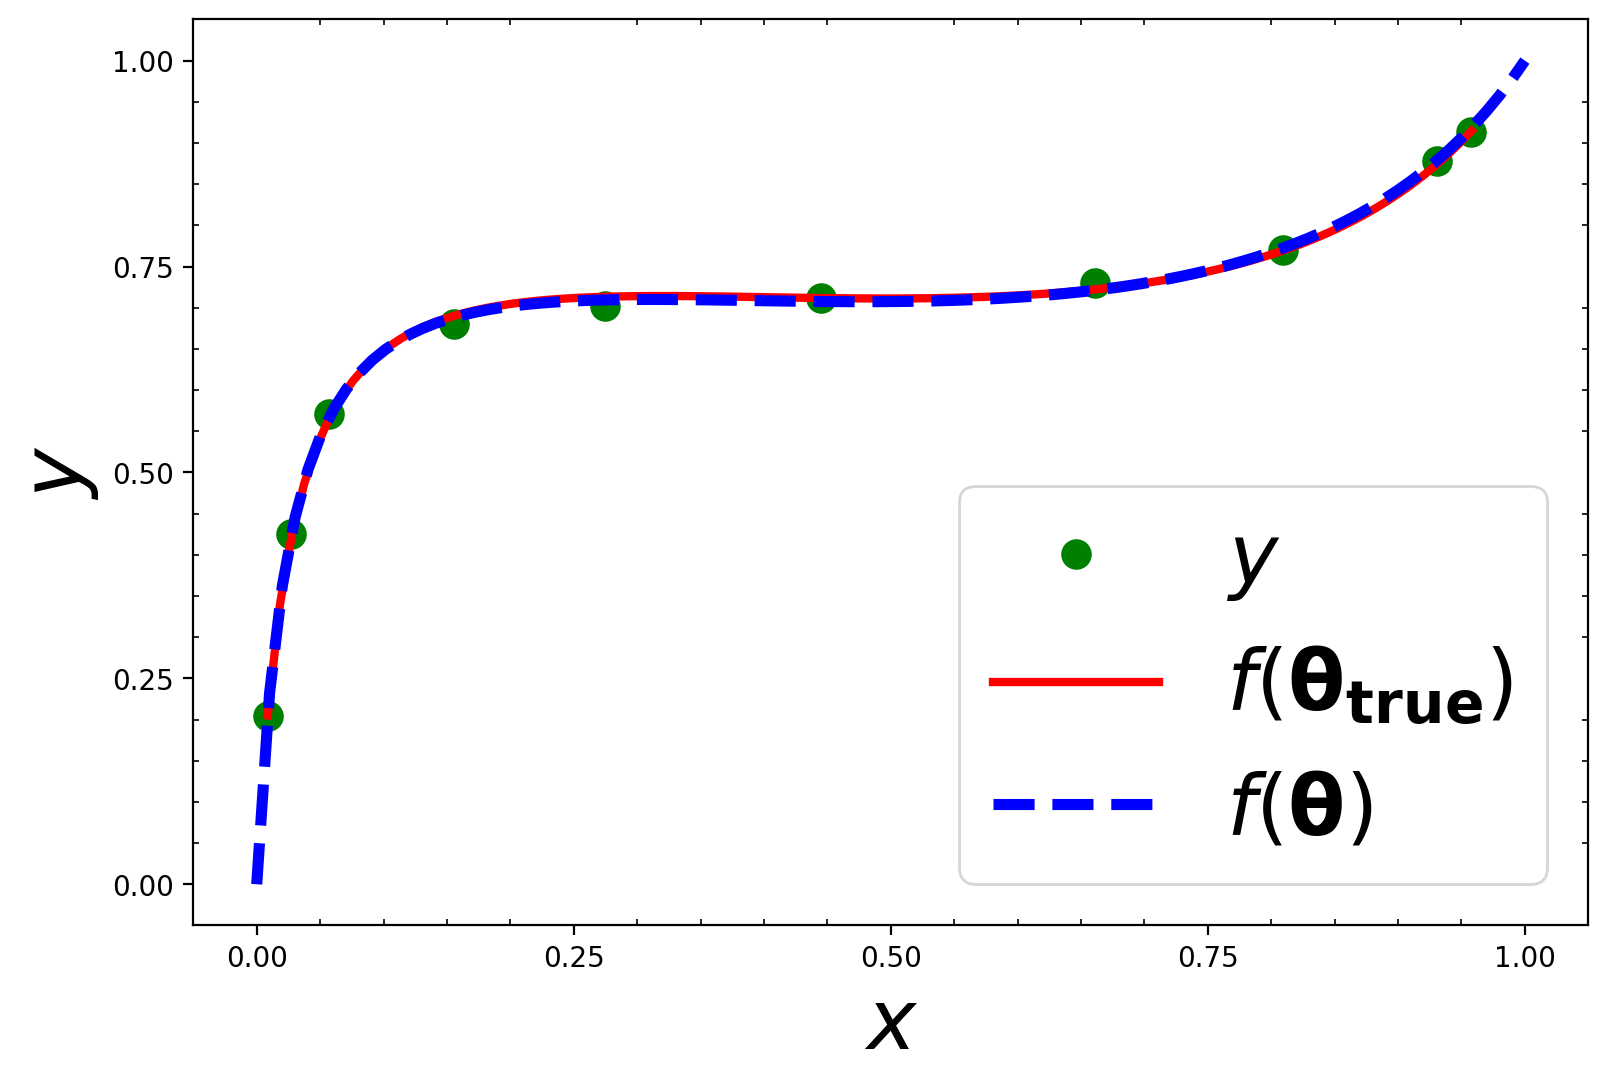

SSE =  0.00032315558109480036


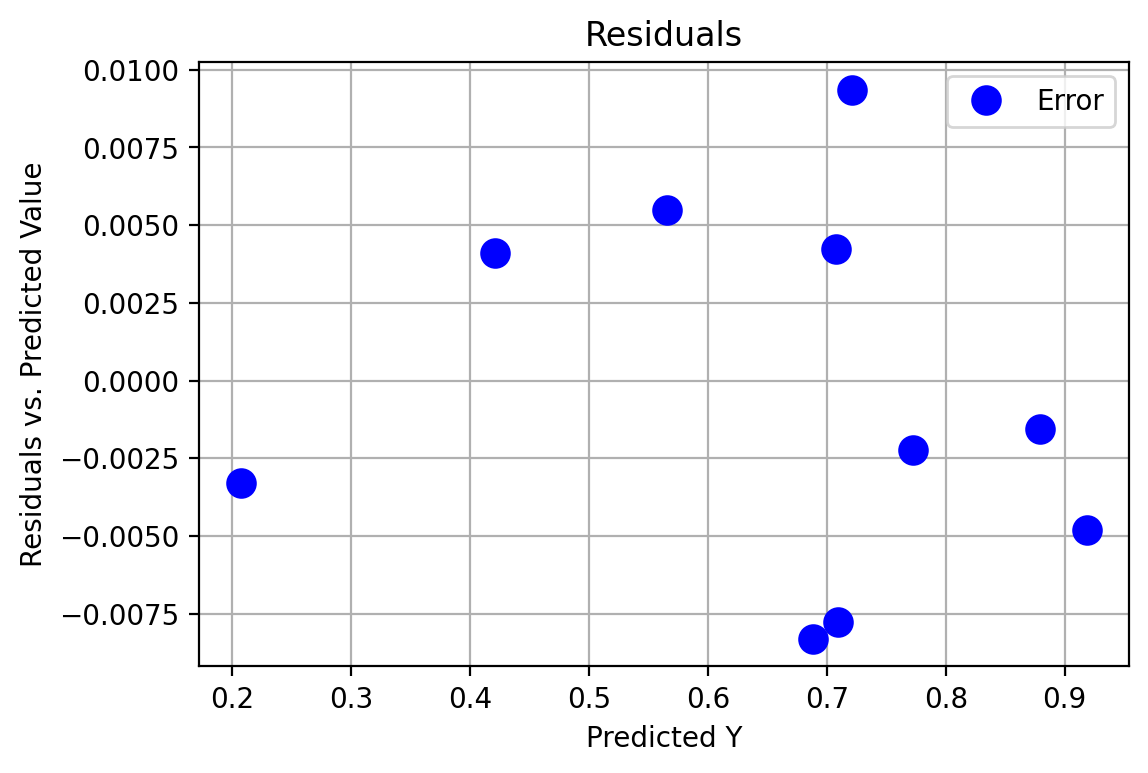

In [329]:
# create plot and compare predictions and experiments
X_pred = np.linspace(bounds_x[0][0], bounds_x[1][0],100).reshape(-1,1)
Y_pred = model(nlr_theta, theta_true, X_pred.reshape(-1,1), indeces_to_consider, argsvals)
print(Y_pred)
plt.figure(figsize = (9,6))
plt.plot(Xexp,Yexp,'.g',markersize=20,label=r'$y$')
plt.plot(X,Y,'r-',linewidth=3,label=r'$f(\mathbf{\theta_{true}})$')
plt.plot(X_pred,Y_pred,'--b',linewidth=4,label=r'$f(\mathbf{\theta})$')
# plt.title("Predictions with $\\theta = [0.994,-1.00]$ vs Synthetic Data")
# plt.title("Predictions with $\\theta = [0.802,-0.757]$ vs Synthetic Data")
plt.legend(loc = "best", fontsize=30) #(bbox_to_anchor=(1.04, 1), borderaxespad=0
plt.xlabel(r'$x$',fontsize=30,fontweight='bold')
plt.ylabel(r'$y$',fontsize=30,fontweight='bold')

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
# plt.grid(True)

# plt.savefig("Figures/sim_true_comp_poster.png", dpi=300, bbox_inches='tight')
plt.show()


##New Cell

#Plot error
print("SSE = ", np.sum(error**2))
plt.plot(Y_nlr_exp,error,"b.",markersize=20, label = "Error")
plt.title("Residuals")
plt.xlabel('Predicted Y')
plt.ylabel('Residuals vs. Predicted Value')
plt.grid(True)
plt.legend()
plt.show()


In [330]:
sigre = np.maximum(std**2, 0.01)
MSE = (error.T @ error)/(len(error) - 2)
Hess = Solution.jac.T @ Solution.jac
Covar = sigre * np.linalg.inv(Hess)
FIM = (1/sigre)*Hess
eigvals, eigvecs = np.linalg.eig(FIM)
k = np.max(eigvals)/np.min(eigvals)
print("MSE = ", MSE)
print("Experimental Variance = ", sigre)
print("Parameter Prediction Standard Deviation: \n", np.sqrt(np.diag(Covar)))
print("Covariance matrix:\n",Covar)
print("Det(FIM) = ", np.linalg.det(FIM))
print("Eigen Values (FIM):\n", eigvals)
print("Eigen Vectors (FIM)\n", eigvecs)
print("Condition Number (FIM): ", k)
print("Degree of precision loss (log10(k) of FIM): ", math.log10(k))

MSE =  4.0394447636850045e-05
Experimental Variance =  0.01
Parameter Prediction Standard Deviation: 
 [511.80725059 352.50115593]
Covariance matrix:
 [[ 261946.66175856 -173138.61928946]
 [-173138.61928946  124257.06493392]]
Det(FIM) =  3.8884151310275596e-10
Eigen Values (FIM):
 [2.63556182e-06 1.47536480e-04]
Eigen Vectors (FIM)
 [[-0.82749318 -0.56147576]
 [ 0.56147576 -0.82749318]]
Condition Number (FIM):  55.97913825649957
Degree of precision loss (log10(k) of FIM):  1.7480262086473346
